# Retail Data Analysis On Csutomer Segmentation And Sales Price Prediction

Course code DATA606

          by
     Wale and Tiru

In [ ]:
# install pyldavis for lda visualization

!pip install pyldavis

# Import Important Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import nltk
import re
from nltk.tokenize import word_tokenize
from gensim.models import TfidfModel

import pyLDAvis
import pyLDAvis.gensim_models
import pickle 

from pprint import pprint
import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
import pyLDAvis.gensim_models as gensimvis
from gensim.models.coherencemodel import CoherenceModel

nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
# Import the wordcloud library
from wordcloud import WordCloud
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
from os import path
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Read The Data From URL 

This block of code will be run first to have an access and be able to load the data file to colab without downloading it into our drive. Besides, since our data is from UCI machine learning repositary, the data will be safe and accessible anytime even if UCI website down.

In [ ]:
#url= "https://drive.google.com/uc?export=download&id=1UAdGe6egzn8VsFFWqcbKHbXJqAwECiu5"

In [ ]:
# df_sheet1= pd.read_excel(url, sheet_name='Year 2009-2010')
# df_sheet2= pd.read_excel(url,sheet_name='Year 2010-2011')


In [ ]:
# print(df_sheet1.shape)
# print(df_sheet2.shape)

(525461, 8)
(541910, 8)


In [ ]:
# Concatenate the two dataframes to get the entire data from 2009 to 2011
#df_all = pd.concat([df_sheet1, df_sheet2])

In [ ]:
#df_all.shape

(1067371, 8)

This pickle portion will be have to contain personal google drive incase you need to load the datafile to your drive. This helps us to save the concatenated dataframe so that we don't need to run the above codes again and again, which take longer time.

In [ ]:
# Pickle the dataframe so that we can load the dataframe directly from the drive
#df_all.to_pickle("/content/drive/Shareddrives/Capstone606/retail_df.pkl")  

# Read The Pickled Data From The Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unpickle the dataframe
unpickled_df = pd.read_pickle("/content/drive/Shareddrives/Capstone606/retail_df.pkl")  
unpickled_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# Change the dataframe name back to the original for simplecity
df_all = unpickled_df

In [ ]:
df_all.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Exploratory  Data Analysis for Retail Data

In [ ]:
df_all.shape

(1067371, 8)

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


The data contains null values in two of its columns, customerId and Description. We keep the customerId column since the number of entries are very significant and we don't want the customer Id for our analysis. However, our analysis uses Descrpition column so we drop the null values in descrption column.

In [ ]:
df_all.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [ ]:
df_all = df_all.dropna(axis=0, subset=['Description'])

## Negative Values of Quantity 

In [ ]:

neg_Q=df_all[df_all.Quantity < 0]
neg_Q

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [ ]:
#df_all['Quantity'] = df_all['Quantity'].abs() #Assigns positives to the orginal column

#or

df_all['Abs Quantity'] = df_all['Quantity'].abs() #Creates a new column keeping old one for records

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
df_all.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Abs Quantity
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,48
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,24


We are converting the negative quantities in the data frame to positives because where the data was collected there was no indication of what the negative values mean and also alot of the negative quantities have positive prices associated with them while some have zero price so we cannot reasonably say for certain that they are somehow related to returns. 

## Zero Price

In [ ]:
zero_p = df_all[df_all.Price ==0]
zero_p

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Abs Quantity
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.0,NaN,United Kingdom,96
283,489463,71477,short,-240,2009-12-01 10:52:00,0.0,NaN,United Kingdom,240
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.0,NaN,United Kingdom,192
3162,489660,35956,lost,-1043,2009-12-01 17:43:00,0.0,NaN,United Kingdom,1043
3168,489663,35605A,damages,-117,2009-12-01 18:02:00,0.0,NaN,United Kingdom,117
...,...,...,...,...,...,...,...,...,...
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,30
536910,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,338
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,NaN,United Kingdom,240
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,NaN,United Kingdom,300


We are droping the entries that have $0 prices for nonw because it will potentially skew our results and will not help our models perform any better. So this is to ensure better performance overall.

In [ ]:
zero_p.shape

(1820, 9)

In [ ]:
df_all= df_all[df_all.Price > 0]

In [ ]:
df_all['Invoice Date'] = pd.to_datetime(df_all['InvoiceDate']).dt.date
df_all['Invoice Time'] = pd.to_datetime(df_all['InvoiceDate']).dt.time

In [ ]:
df_all.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Abs Quantity,Invoice Date,Invoice Time,Sale
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009-12-01,07:45:00,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009-12-01,07:45:00,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009-12-01,07:45:00,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,48,2009-12-01,07:45:00,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,24,2009-12-01,07:45:00,30.0


Creating our Sale column to be used later for our prediction model. It uses the price multiplied by the quantity column to come up with the sale price. 

In [ ]:
# Create the sale column in the dataframe
df_all['Sale'] = df_all['Abs Quantity'] * df_all['Price']
df_all.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Abs Quantity,Invoice Date,Invoice Time,Sale
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009-12-01,07:45:00,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009-12-01,07:45:00,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009-12-01,07:45:00,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,48,2009-12-01,07:45:00,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,24,2009-12-01,07:45:00,30.0


The following screenshots are taken from tableau to see the visualizations we can draw from the retail data that makes more sense to the untrained eye. 

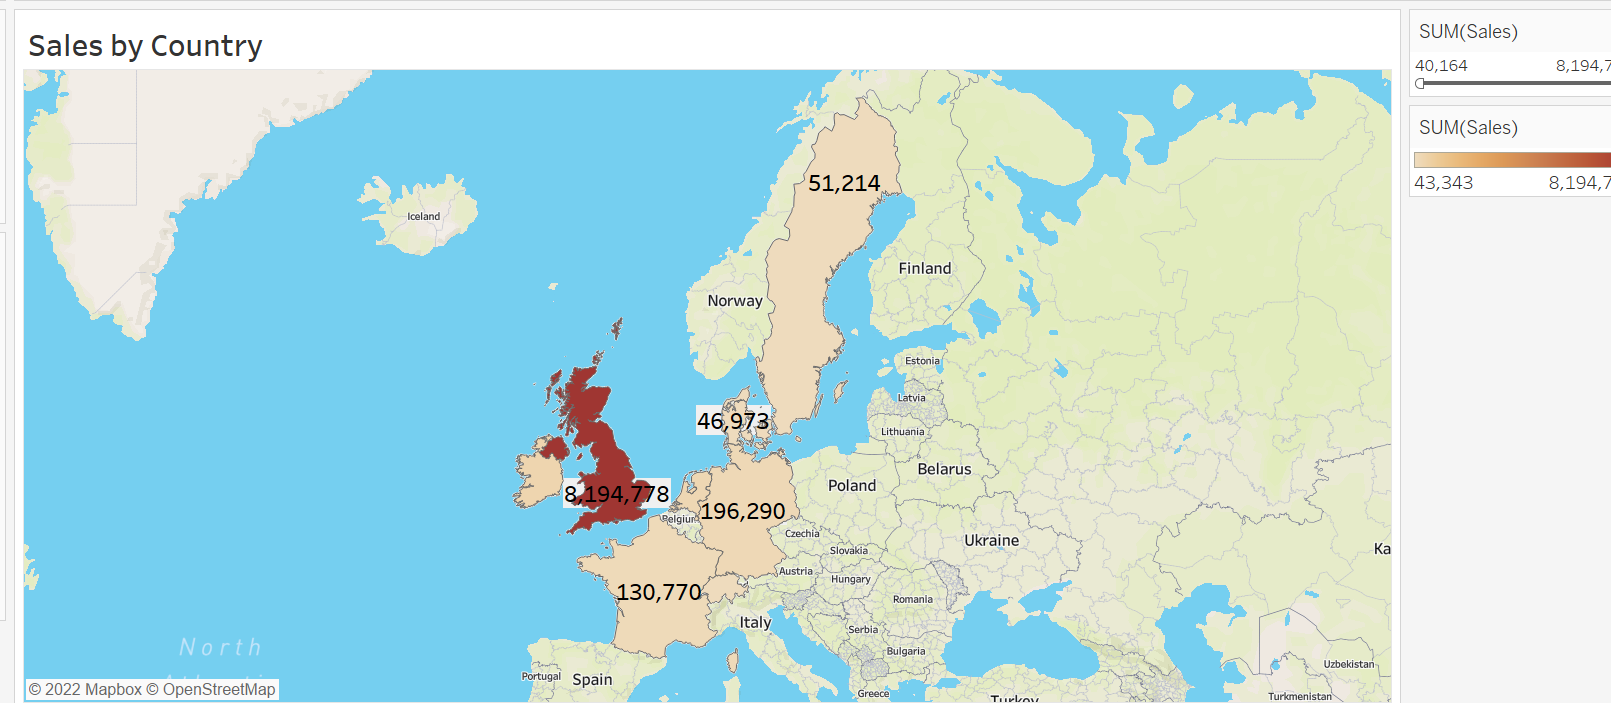

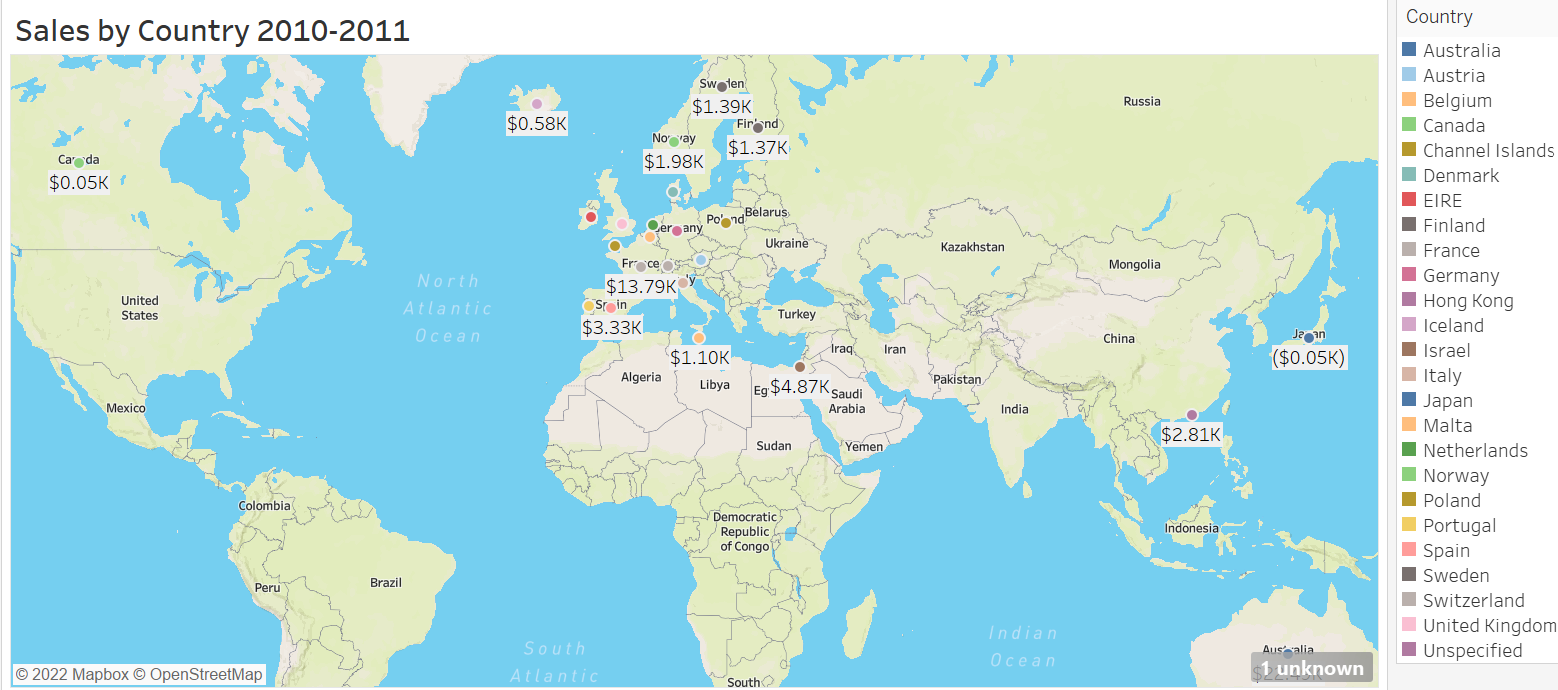

The above two maps show the total sales for each country from 2009 to 2011.

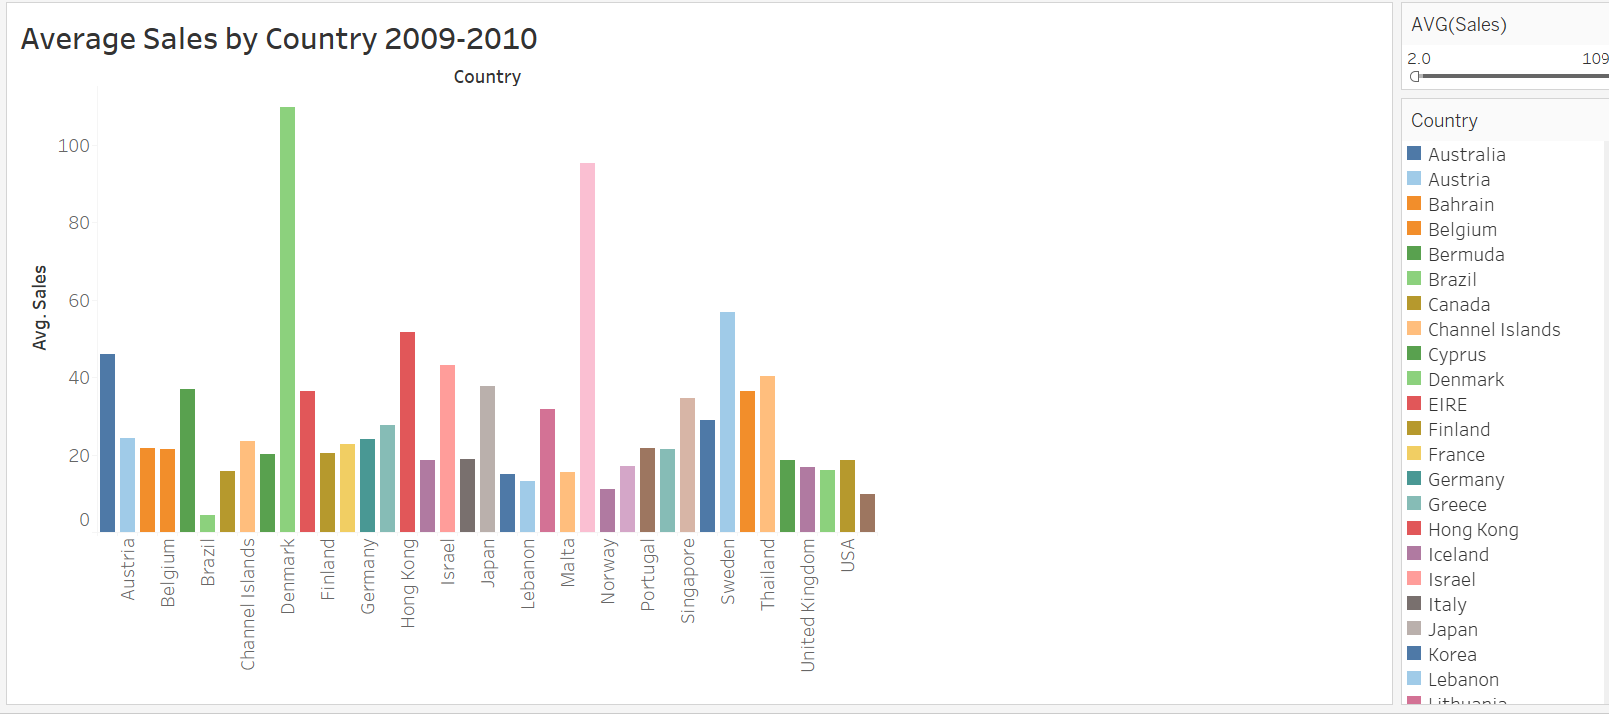

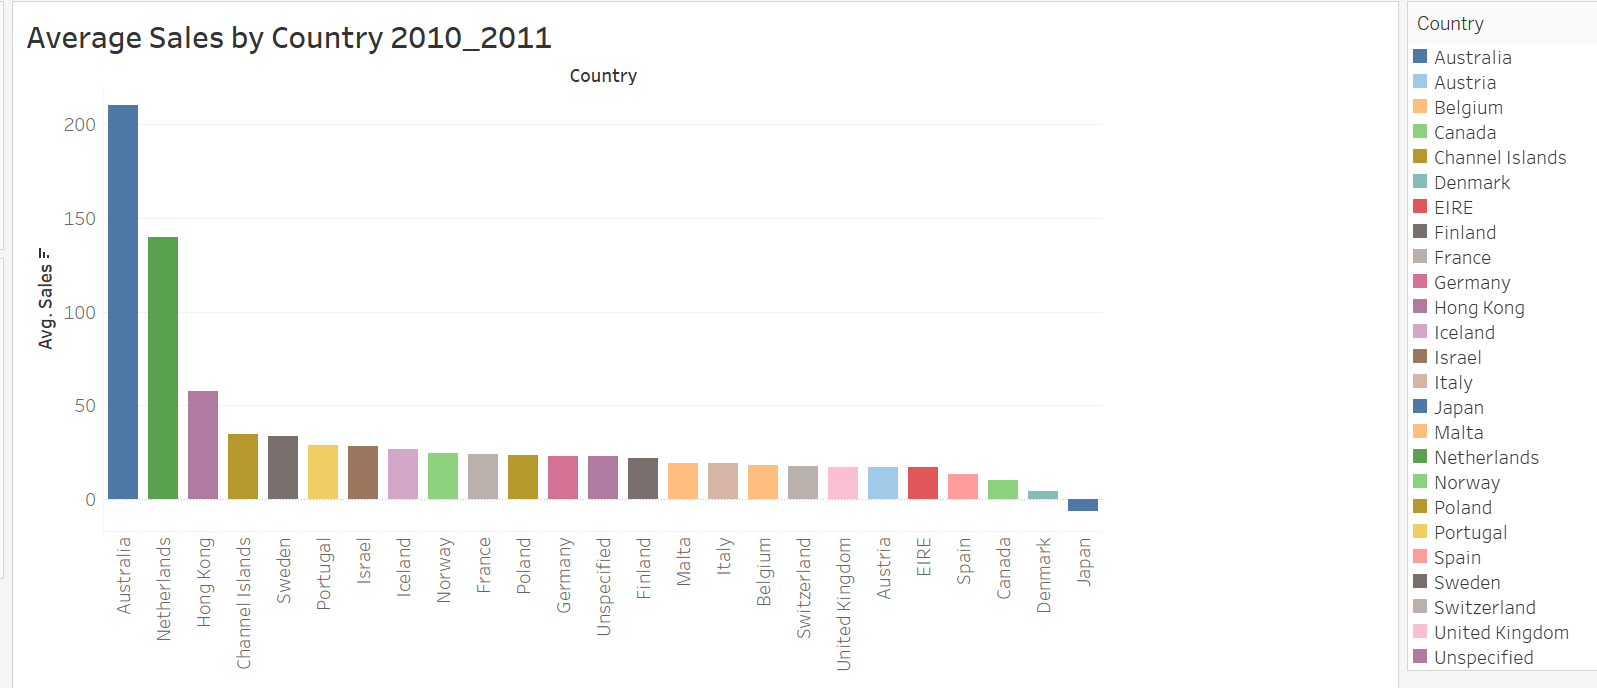

The average sales by countries from 2009 to 2011, on the first graph from 2009 to 2010 Denmark had the largest average sale wheras, on the second graph from 2010 to 2011 Australia took first place in average sales. 

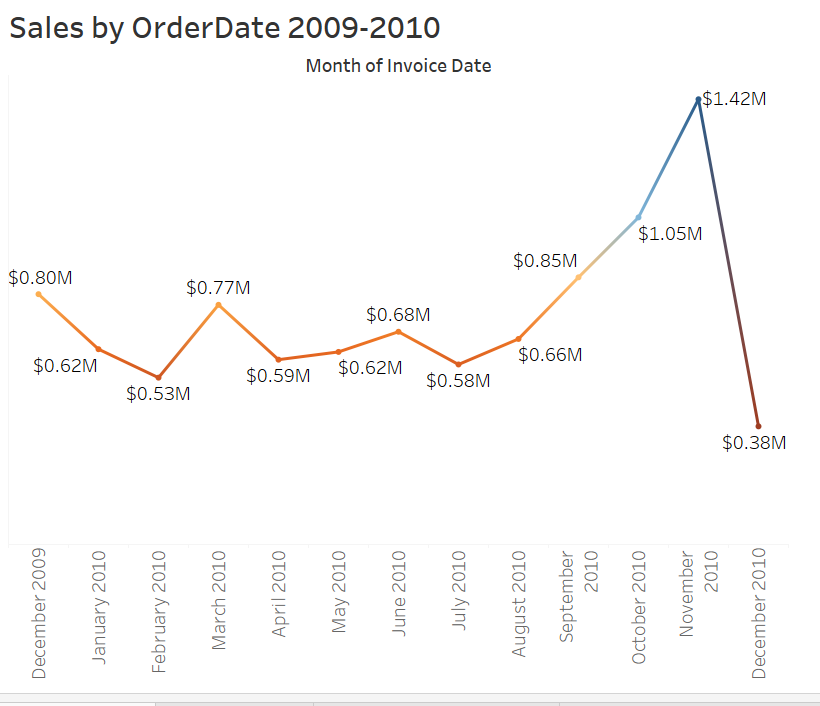


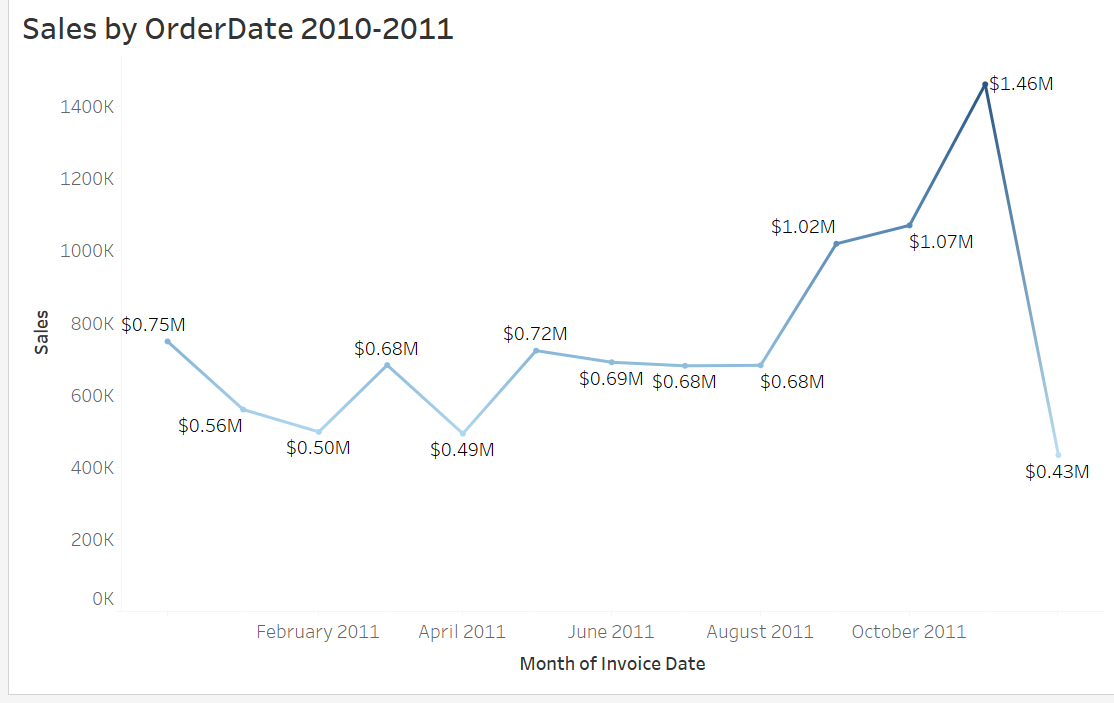

Sales by invoce dates shows the total sales by dates. As we can see from the two graphs above, the sales have some seasonal trends and fluctuating throughout the year except it hits its peak around end of october, which makes sense, that is the holiday season and gets its lowest around end of December. This is a good visualization to help corporate advertisers see what sections of the year need better advertising and which sections they could save on advertisment costs.

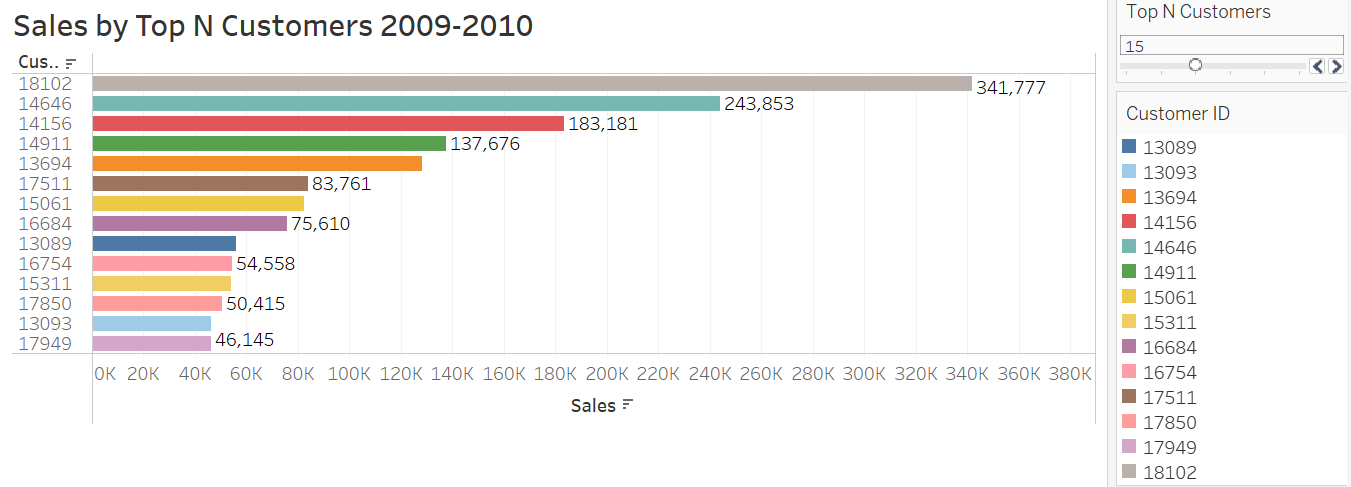



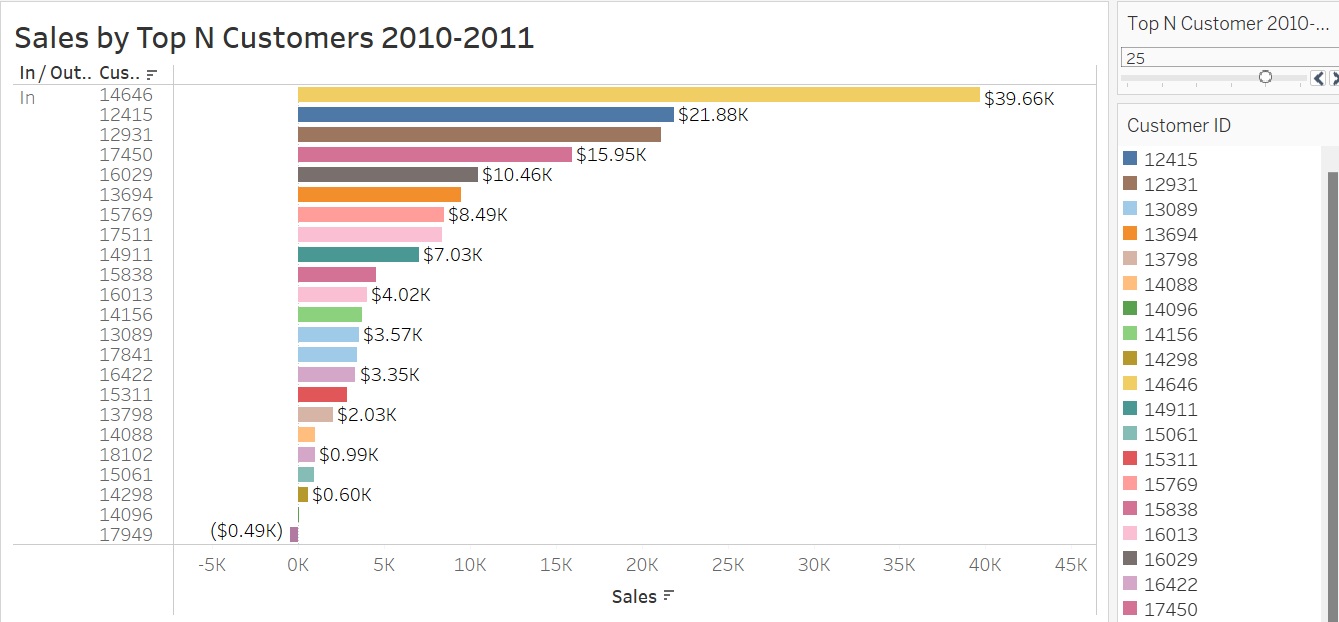

Sales by top N customers graphs show that the top 5 to 30 customers by  sales from 2009 to 2011. The top customers who purchased highest sales during those years. 

## The Tableau Dashboard links attched below

https://public.tableau.com/app/profile/tiru4468/viz/Retail_DataAnalysis2009-2010/CustomerAnalysisfor2009to2010?publish=yes


https://public.tableau.com/app/profile/tiru4468/viz/Retail_DataAnalysis2010-2011/2010-2011CustomerDataAnalysis?publish=yes


## Addtional Visualization

Text(0, 0.5, 'Sales')

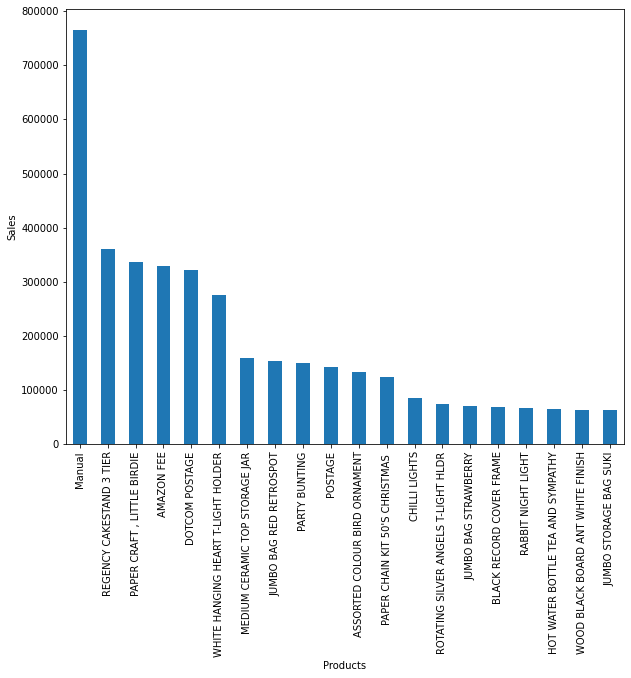

In [ ]:
plot = df_all.groupby("Description")["Sale"].sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(10,8))#nlargest(1).
plt.xlabel("Products")
plt.ylabel("Sales")

Visualization above shows the top 20 products with the highest sales. 

# Natural Languge Processing for data analysis

## Preprocessing the data (Description column)

*  Tokenization : Split the text into words
*   Normalization : Lemmetization, Stemming etc. to transform a word into its 
base form.
*   Remove Stopwords 
*   Change the words into Lowercase form

*   Remove punctuations, special characters, single quotes, numbers using Regular Expressions (re)









### Cleaning the data

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'use','15cm','set','large','small','medium'])
def cleandata(desc):
    
    tokens = word_tokenize(str(desc))
    # convert to lower case
    tokens = [w.lower() for w in tokens] 
    # Remove stop words 
    tokens = [w for w in tokens if not w in stop_words]
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(tokens))
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # remove single quotes
    text = re.sub("\'", "", text)  
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    # Remove numbers
    text = re.sub(r'\d+','' , text)
    #text= text.split()
    
    return text
df_all['Desc_processed']= df_all['Description'].apply(cleandata)  # put the processed text into the dataframe

df_all.tail()



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Abs Quantity,Invoice Date,Invoice Time,Sale,Desc_processed
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,6,2011-12-09,12:50:00,12.60,children apron dolly girl
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,4,2011-12-09,12:50:00,16.60,childrens cutlery dolly girl
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,4,2011-12-09,12:50:00,16.60,childrens cutlery circus parade
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,3,2011-12-09,12:50:00,14.85,baking piece retrospot
541909,581587,POST,POSTAGE,1,2011-12-09 12:50:00,18.00,12680.0,France,1,2011-12-09,12:50:00,18.00,postage


In the function above we are cleaning the data specifically in the description column to prepare it for our NLP model later on. We are clearing the description column of any unnecessary stop words, numbers and symbols that won't assist in our model performance. 

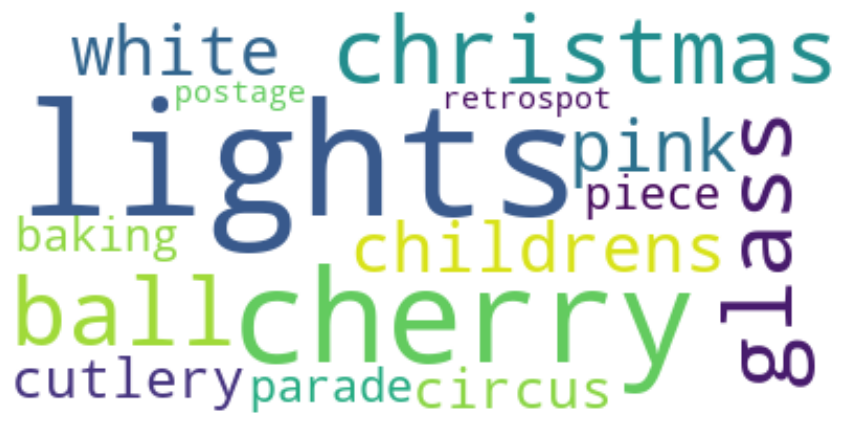

In [ ]:
# Plot wordcloud to see the words' frequency

plt.figure( figsize=(15,10))
freq_words = str(df_all['Desc_processed'].values)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(freq_words)
# Visualize the word cloud
#wordcloud.to_image()
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")

With our cleansed description column we were able to create a word cloud which shows the most frequent words in the new column. The bigger and darker the word in the word cloud the more frequent it appears in the data. 

## Gensim Application

In [ ]:
# This function helps us to lowercases, tokenizes and de-accents (optional) the document

def gen_words(description):
    words = []
    for word in description:
        new = gensim.utils.simple_preprocess(str(word), deacc=True)
        words.append(new)
    return (words)

doc_words = gen_words(list(df_all['Desc_processed'].values))

In [ ]:
len(doc_words)

1061164

We implemented Gensim because it is one of the fastest libraries for training of vector embeddings. Core algorithms in Genism use battle tested and highly optimized and parallelized c routines. We've used it to process our text in the new "Description" column of the dataframe. It helps us to lower case, tokenize, and de accents the data and yields outputs that are unicode strings that do not require further processing. 

In [ ]:
# Build bigram and trigram:  which help the model to understand words better incase it can't recognize individual words.

bigram_phrases = gensim.models.Phrases(doc_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[doc_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(desc):
    return([bigram[doc] for doc in desc])

def make_trigrams(desc):
    return ([trigram[bigram[doc]] for doc in desc])

data_bigrams = make_bigrams(doc_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['christmas', 'glass', 'ball', 'lights']


In [ ]:
len(data_bigrams_trigrams)

1061164

Bigrams and trigrams are words that are used consistently together and have distinct meanings when used together. Bigram is the instance of two multi word tokens (two words that have a distinct meaning when used together). Trigram is the same as a bigram but just has an instance of three multi word tokens. These are used in case it becomes difficult to recognize individual words. Two heads are better than one or in this case two words.

In [ ]:
# In this stage words will be vectorized, change words into numerical values in a way the model can understand
# Create dictionary

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]  # Create a bow, each word in a document with its frequency

# Create tfidf model to remove words which have high frequency but are not important to form the topics
tfidf = TfidfModel(corpus, id2word=id2word)

# Remove words with very low frequency probablity
low_value = 0.03
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

In [ ]:
len(corpus)

1061164

Term Frequency - Inverse Docutment Frequency (TFIDF) allows us to measure the importance of terms, in this case it will be from our newly processed description column. It also helps us filter some words that may slip through because of their high frequency but in the end are not important to form our topics. 


TF - measures the frequency of a word in a document

DF - measures the importance of documents in a whole set of the corpus.Or the number of documents in which the word is present.

IDF - The inverse of DF

## Topic Modeling

Topic Modelling is a process of unsupervised learning to extract the main topics (represented as a set of words) that occur in a collection of documents.

### Build The Latent Dirichlet Allocation (LDA)  Model

LDA is used to classify text in a document to a particular topic.
In the first model we used 10 number of topics to see how the model performs.

In [ ]:
lda_model_1 = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

### Visualize The Model Performance

In [ ]:

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_1, corpus, dictionary=lda_model_1.id2word, mds='mmds')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.016744  0.077298       1        1  13.726071
2      0.050753 -0.430845       2        1  12.366403
8     -0.375708 -0.140234       3        1  11.047601
0     -0.239423  0.402217       4        1  10.423262
9      0.352970 -0.335140       5        1  10.396931
6      0.416357 -0.043889       6        1  10.143509
1      0.100030  0.465801       7        1   8.368753
7     -0.262022 -0.409162       8        1   8.257473
5     -0.461495  0.142668       9        1   7.721299
4      0.401795  0.271286      10        1   7.548697, topic_info=           Term          Freq         Total Category  logprob  loglift
145         red  94078.000000  94078.000000  Default  30.0000  30.0000
127     vintage  82204.000000  82204.000000  Default  29.0000  29.0000
1     christmas  81963.000000  81963.000000  Default  28.0000  28.0000
134         bag  81229.000000  81229.000000  Default  27.0000  27.0000
157   retrospot  61085.000000  61085.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1805     marker   3367.375655   3368.285061  Topic10  -4.5243   2.5835
605      pencil   3345.834809   3346.744243  Topic10  -4.5307   2.5835
291    diamante   3259.566427   3260.475907  Topic10  -4.5569   2.5835
524       magic   3109.063978   3109.973405  Topic10  -4.6041   2.5835
318      hanger   2955.449430   2956.358849  Topic10  -4.6548   2.5835

[332 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
381       1  0.999638   airline
1361      7  0.999926     alarm
310      10  0.999940  alphabet
500       7  0.999669     angel
674       2  0.999622   animals
...     ...       ...       ...
252       2  0.999967  woodland
165       1  0.999913      wrap
93        3  0.999902    wreath
196       1  0.999914    yellow
119       1  0.999932      zinc

[306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 9, 1, 10, 7, 2, 8, 6, 5])

From the above graph we can see that the model is able to group 10 seperate topics perfectly. To double down we are going to evaluate the model with performance metrics. We used Coherence and Perplexity evaluating metrics

The function below helps to get the optimal number of topics with highest coherence value. We chose to compute up to 50 topics and the highest coherence value will be chosen. We chose 50 because we wanted to test the computation, we can always increase but after a certain number of topics the coherence and perplexity will not better any further.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
 
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

[Code's Source](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels)

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_bigrams_trigrams, start=2, limit=50, step=1)


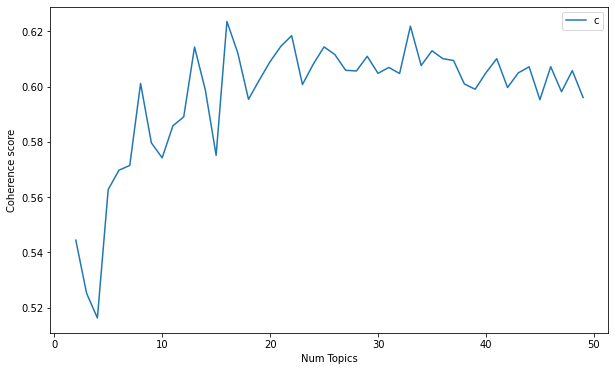

In [ ]:
# Plot the result 

plt.figure(figsize=(10,6))
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

The above graph shows the number of topics with their coresponding coherence scores. 16 topics looks optimal in this model. Below we can see the exact number of topics with coherence values.The computation took more than 2 and half hours.

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5444
Num Topics = 3  has Coherence Value of 0.5252
Num Topics = 4  has Coherence Value of 0.5163
Num Topics = 5  has Coherence Value of 0.5628
Num Topics = 6  has Coherence Value of 0.5698
Num Topics = 7  has Coherence Value of 0.5715
Num Topics = 8  has Coherence Value of 0.6012
Num Topics = 9  has Coherence Value of 0.5797
Num Topics = 10  has Coherence Value of 0.5742
Num Topics = 11  has Coherence Value of 0.5858
Num Topics = 12  has Coherence Value of 0.5891
Num Topics = 13  has Coherence Value of 0.6144
Num Topics = 14  has Coherence Value of 0.5988
Num Topics = 15  has Coherence Value of 0.5751
Num Topics = 16  has Coherence Value of 0.6236
Num Topics = 17  has Coherence Value of 0.6123
Num Topics = 18  has Coherence Value of 0.5954
Num Topics = 19  has Coherence Value of 0.6024
Num Topics = 20  has Coherence Value of 0.6091
Num Topics = 21  has Coherence Value of 0.6146
Num Topics = 22  has Coherence Value of 0.6185
Num Topics = 23  has 

The result shows that 16 topics has the highest coherence value 0.6236. We created another model with 16 topics.

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1],
                                           id2word=id2word,
                                           num_topics=16, # the number of topics with highest coherence score
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [ ]:
# Save the Model
lda_model.save('/content/drive/Shareddrives/Capstone606/retail_16_topic_lda.model')

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.246*"pink" + 0.120*"paper" + 0.064*"wood" + 0.061*"gift" + 0.057*"chain" '
  '+ 0.051*"trinket" + 0.042*"bunting" + 0.042*"pot" + 0.028*"game" + '
  '0.028*"napkins"'),
 (1,
  '0.214*"vintage" + 0.148*"design" + 0.147*"bag" + 0.071*"lunch" + '
  '0.063*"spaceboy" + 0.042*"mug" + 0.035*"wicker" + 0.030*"cards" + '
  '0.028*"notebook" + 0.019*"apples"'),
 (2,
  '0.119*"jumbo" + 0.094*"bag" + 0.081*"glass" + 0.070*"paisley" + '
  '0.058*"lights" + 0.057*"silver" + 0.048*"ribbons" + 0.047*"antique" + '
  '0.041*"babushka" + 0.029*"skulls"'),
 (3,
  '0.127*"metal" + 0.098*"sign" + 0.085*"kit" + 0.072*"hand" + 0.068*"warmer" '
  '+ 0.063*"dolly" + 0.025*"hook" + 0.020*"coffee" + 0.019*"yellow" + '
  '0.014*"scales"'),
 (4,
  '0.340*"red" + 0.144*"white" + 0.097*"mini" + 0.082*"cases" + 0.046*"cup" + '
  '0.039*"charlotte" + 0.029*"lantern" + 0.022*"shopper" + 0.016*"spotty" + '
  '0.016*"biscuit"'),
 (5,
  '0.164*"bottle" + 0.153*"hot" + 0.144*"water" + 0.088*"love" + '
  '0.046*"c

In [ ]:
# Visualize the new model with 34 Topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
14    -0.477426  0.005255       1        1  9.382922
1      0.293494 -0.237980       2        1  9.120578
7      0.490414 -0.151074       3        1  7.330494
4      0.466323  0.116382       4        1  7.244567
12     0.357629  0.319585       5        1  6.645452
2      0.240243 -0.443341       6        1  6.581981
6     -0.397475 -0.328325       7        1  6.489459
3     -0.170321 -0.459115       8        1  6.269199
9     -0.143022  0.115361       9        1  6.086961
11    -0.437144  0.242242      10        1  6.085561
13     0.157163  0.044808      11        1  5.572956
0      0.022690 -0.397224      12        1  5.317528
15     0.170192  0.468428      13        1  5.008894
8     -0.031647  0.427759      14        1  4.461256
10    -0.257372  0.425349      15        1  4.286846
5     -0.283742 -0.148112      16        1  4.115347, topic_info=           Term           Freq          Total Category  logprob  loglift
145         red  101457.000000  101457.000000  Default  30.0000  30.0000
1     christmas   77205.000000   77205.000000  Default  29.0000  29.0000
127     vintage   80133.000000   80133.000000  Default  28.0000  28.0000
30        heart   76448.000000   76448.000000  Default  27.0000  27.0000
5          pink   53786.000000   53786.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
92       orange     898.689830     899.658283  Topic16  -5.2386   3.1894
2027      mould     829.651136     830.619588  Topic16  -5.3186   3.1893
337    mushroom     788.449575     789.418027  Topic16  -5.3695   3.1892
1882       bomb     777.014693     777.983145  Topic16  -5.3841   3.1892
2139        sex     714.856040     715.824492  Topic16  -5.4675   3.1891

[519 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1341     13  0.999666   acrylic
381       8  0.999518   airline
1361      3  0.999871     alarm
310      13  0.999908  alphabet
500       5  0.999764     angel
...     ...       ...       ...
165      10  0.999957      wrap
93        1  0.999744    wreath
130       6  0.999703   writing
196       8  0.999888    yellow
119       1  0.999948      zinc

[492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 8, 5, 13, 3, 7, 4, 10, 12, 14, 1, 16, 9, 11, 6])

With 16 different topics we can see the difference it had from the version that only had 10 topics. Given that 16 does give our highest Coherence value but in terms of Intertopic Distance Map, 10 topics are more even sizes overall which number would be better to use truly? (Open Question)

## Evaluate the LDA model by Perplexity and Coherence

In [ ]:
# Evaluating the LDA model with optimal topics

print('\nPerplexity with optimal topics: ', lda_model.log_perplexity(corpus,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score with optimal topics: ', coherence_lda)


Perplexity with optimal topics:  -6.8862708051314145

Coherence Score with optimal topics:  0.6255755058618131


In [ ]:
# Evaluation for the LDA Model with 10 topics

print('\nPerplexity with 10 topics: ', lda_model_1.log_perplexity(corpus,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_with10 = CoherenceModel(model=lda_model_1, texts=data_bigrams_trigrams, dictionary=id2word , coherence='c_v')
coherence_lda_10 = coherence_model_lda_with10.get_coherence()
print('\nCoherence Score with 10 topics: ', coherence_lda_10)


Perplexity with 10 topics:  -6.8468842979479065

Coherence Score with 10 topics:  0.6338323184233358


From the evaluation metrics, we can learn that model with 10 topics has the highest coherence and a little high Perplexity score than the model with 16 topics.